In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


sys.path.append('unpast/') # path to UnPaSt
from unpast.run_unpast import unpast

from unpast.utils.method import prepare_input_matrix, zscore
from unpast.utils.io import read_bic_table, write_bic_table 

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#exprs_file = "data/HH.exprs.tsv.gz" #"OV_cancer/210706_normalizedcounts.tsv"
exprs_file = "../data/UKE_244.exprs.tsv.gz" 
annot = pd.read_csv("../data/UKE.sample_annotation_v4_181samples.tsv",sep ="\t",index_col=0)

out_dir = "unpast_results/" 
basename = 'UKE_244'

exprs = pd.read_csv(exprs_file,sep="\t",index_col=0)
print(exprs.shape)
exprs.head(3)

(23758, 244)


,T0063,T0096,T0103,T0249,T0294,T0305,T0315,T0342,T0430,T0644,...,T6985,T6987,T6990,T6991,T6993,T6995,T6999,T7001,T7002,T7003
ENSG00000012124,9.027778,7.575057,7.261707,9.946216,9.903127,7.871454,9.29040,9.726680,9.152180,9.247163,...,5.218529,5.232677,7.880272,4.017847,7.706173,4.629797,5.397713,8.116292,9.344000,9.764757
ENSG00000260083,3.660087,3.141124,2.923667,3.939617,3.530985,3.802634,3.37083,3.531991,3.817024,4.534004,...,2.437952,2.449817,3.532084,3.738694,2.859947,4.268662,3.101250,1.871275,2.633388,1.929429
ENSG00000176887,9.648030,4.776085,6.083604,7.272087,2.432884,6.795860,0.00000,6.245121,8.322694,3.000023,...,8.648666,6.330015,8.254377,3.632195,3.616804,4.629797,5.111689,4.083328,6.367058,5.607441


In [3]:
# functions to rename genes 
gene_info = pd.read_csv("../data/gene_id_mapping.tsv", sep ="\t",index_col=0)
gene_info.set_index("ensembl_gene_id",inplace=True)
ens2hgnc = gene_info["hgnc_symbol"].dropna().to_dict() 
def rename_gene(g,mapper=ens2hgnc, not_mapped = "", keep_not_mapped = False):
    if g in ens2hgnc.keys():
        return mapper[g]
    else:
        if keep_not_mapped:
            return g
        else:
            return not_mapped
        
def rename_genes_in_biclusters(biclusters, rename_gene_func = rename_gene):
    renamed_biclusters = biclusters.copy()
    renamed_biclusters["genes"] = renamed_biclusters["genes"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_up"] = renamed_biclusters["genes_up"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_down"] = renamed_biclusters["genes_down"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    return renamed_biclusters

def rename_genes_in_exprs(data, rename_gene_func = rename_gene):
    renamed_data = data.copy()
    renamed_data.index = [rename_gene_func(x, keep_not_mapped=True) for x in renamed_data.index ]
    # drop duplicates 
    renamed_data = renamed_data[~renamed_data.index.duplicated()]
    return renamed_data

In [4]:
analysis_seed =  42
n_runs = 10
seeds = []
random.seed(analysis_seed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)
biclusters = []

generate  10  seeds [670487, 116739, 26225, 777572, 288389, 256787, 234053, 146316, 772246, 107473]


In [5]:
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
biclusters = []
for seed in seeds:
    # find and save biclusters
    fname = out_dir+basename+".seed="+str(seed)+suffix
    if not os.path.exists(fname):
        results = unpast(exprs_file,
                      basename,
                      out_dir=out_dir,
                      #load=True,
                      seed = seed,
                      verbose = False
                     )
    else:
        results = read_bic_table(fname)
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed=%s\tn_biclusters: %s"%(seed, results.shape[0]))


seed=670487	n_biclusters: 205
seed=116739	n_biclusters: 228
seed=26225	n_biclusters: 208
seed=777572	n_biclusters: 201
seed=288389	n_biclusters: 194
seed=256787	n_biclusters: 213
seed=234053	n_biclusters: 215
seed=146316	n_biclusters: 200
seed=772246	n_biclusters: 197
seed=107473	n_biclusters: 227


In [6]:
from unpast.utils.consensus import make_uke_bics
# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
uke_bics = make_uke_bics(biclusters, 
                                                 exprs_z, 
                                                 seed = analysis_seed,
                                                 verbose = True,
                                                 frac_runs=0.2,
                                                 plot = False
                                                )


uke_bics

265 s for similarity matrix
	Running Louvain ...
		modularity: newman
	curve type: increasing
	Louvain runtime: modules detected in 5.11 s.
	modules: 234, not clustered features 49 
		similarity cutoff: 0.43 modularity: 0.994
keep genes included in at least 2 merged biclusters
all consensus biclusters: 283
detected 2+ times:234
10 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,3.34853,2,111,"{ENSG00000236209, ENSG00000204792}","{T6313, T6931, T1533, T6343, T6726, T0928, T69...",{},"{ENSG00000236209, ENSG00000204792}","{19402, 22351}","{1, 2, 5, 7, 9, 10, 14, 21, 22, 23, 24, 25, 29...",DOWN,10,"{seed=146316_0, seed=107473_0, seed=772246_0, ..."
1,2.673952,2,75,"{ENSG00000241945, ENSG00000160221}","{T6632, T6999, T6283, T6313, T4032, T3858, T67...","{ENSG00000160221, ENSG00000241945}",{},"{22705, 3483}","{130, 131, 133, 134, 139, 14, 15, 16, 17, 18, ...",UP,10,"{seed=107473_3, seed=288389_3, seed=256787_51,..."
2,2.454886,2,57,"{ENSG00000187010, ENSG00000261349}","{T1190, T6754, T6593, T1189, T6632, T0249, T67...",{},"{ENSG00000187010, ENSG00000261349}","{9330, 21459}","{128, 1, 2, 3, 133, 134, 135, 8, 136, 11, 12, ...",DOWN,7,"{seed=256787_3, seed=146316_6, seed=288389_5, ..."
3,2.268912,2,97,"{ENSG00000174963, ENSG00000152977}","{T6995, T0249, T6313, T6965, T6343, T6696, T62...","{ENSG00000174963, ENSG00000152977}",{},"{22442, 8551}","{3, 6, 10, 28, 37, 39, 40, 41, 42, 43, 44, 45,...",UP,10,"{seed=777572_6, seed=256787_99, seed=107473_7,..."
4,2.184297,4,14,"{ENSG00000285822, ENSG00000233515, ENSG0000023...","{T6726, T6610, T2434, T0430, T6759, T6936, T60...","{ENSG00000285822, ENSG00000231421, ENSG0000023...",{},"{17842, 19121, 1698, 469}","{161, 2, 98, 130, 131, 8, 44, 109, 176, 213, 1...",UP,10,"{seed=777572_9, seed=288389_10, seed=26225_7, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
229,1.36204,5,84,"{ENSG00000206129, ENSG00000133710, ENSG0000025...","{T7001, T6313, T6798, T6955, T6771, T0802, T66...",{},"{ENSG00000206129, ENSG00000133710, ENSG0000025...","{13380, 19623, 13143, 5626, 3422}","{0, 7, 9, 11, 12, 13, 14, 17, 22, 23, 36, 44, ...",DOWN,10,"{seed=26225_164, seed=288389_64, seed=116739_5..."
230,1.357227,5,111,"{ENSG00000285898, ENSG00000237442, ENSG0000027...","{T6283, T6931, T6955, T0430, T6297, T6832, T08...","{ENSG00000285898, ENSG00000237442, ENSG0000027...",{},"{2180, 999, 4743, 1461, 7254}","{6, 8, 9, 10, 11, 12, 13, 16, 18, 19, 20, 24, ...",UP,5,"{seed=26225_165, seed=256787_98, seed=26225_16..."
231,1.343949,2,84,"{ENSG00000185860, ENSG00000260704}","{T7001, T0249, T6798, T2021, T6746, T6696, T67...","{ENSG00000185860, ENSG00000260704}",{},"{13107, 12590}","{0, 3, 4, 6, 7, 15, 16, 17, 18, 26, 32, 35, 37...",UP,2,"{seed=234053_202, seed=256787_206}"
232,1.322796,6,87,"{ENSG00000180772, ENSG00000099869, ENSG0000018...","{T3974, T6283, T6931, T1533, T6343, T6696, T04...","{ENSG00000180772, ENSG00000099869, ENSG0000018...",{},"{13056, 8710, 14450, 3318, 6556, 5116}","{0, 4, 6, 8, 17, 18, 19, 20, 21, 22, 23, 25, 2...",UP,10,"{seed=288389_172, seed=116739_224, seed=234053..."


In [7]:
outfile = out_dir+basename+".consensus_seed="+str(analysis_seed)+".n_runs=10.biclusters.tsv"
#write_bic_table(uke_bics,outfile)
outfile

'unpast_results/UKE_244.consensus_seed=42.n_runs=10.biclusters.tsv'

In [8]:
outfile = out_dir+basename+".consensus_seed="+str(analysis_seed)+".n_runs=10.biclusters.tsv"
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
uke_bics = read_bic_table(outfile)
uke_bics["genes_renamed"] = uke_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics.shape[0]

234

In [9]:
# filter out poor biomarker candidates
uke_bics["genes_renamed"] = uke_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics = uke_bics.loc[uke_bics['SNR']>1.5,:]
uke_bics = uke_bics.loc[uke_bics['n_genes']>=2,:]
uke_bics.shape[0]

177

In [10]:
# subset biclusters to 181 samples used in survival analysis
uke_bics["samples"] =  uke_bics["samples"].apply(lambda x : x.intersection(set(annot.index.values)))
uke_bics["n_samples"] = uke_bics["samples"].apply(lambda x :len(x) )
flip_bics = uke_bics.loc[uke_bics["n_samples"]>annot.shape[0]/2,:].index.values
uke_bics.loc[flip_bics,"samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x : set(annot.index.values).difference(x))
uke_bics.loc[flip_bics,"n_samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x :len(x) )
d = {"UP":"DOWN","DOWN":"UP","BOTH":"BOTH"}
uke_bics.loc[flip_bics,"direction"] = uke_bics.loc[flip_bics,"direction"].apply(lambda x: d[x])
genes_up  = uke_bics.loc[flip_bics,"genes_up"].copy()
genes_down  = uke_bics.loc[flip_bics,"genes_down"].copy()
uke_bics.loc[flip_bics,"genes_up"] = genes_down
uke_bics.loc[flip_bics,"genes_down"] = genes_up 
uke_bics.loc[flip_bics,:]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
16,1.977286,3,90,"{ENSG00000218274, ENSG00000218048, ENSG0000014...","{T2497, T6717, T6874, T4720, T6750, T6390, T49...",{},"{ENSG00000218274, ENSG00000218048, ENSG0000014...","{5480, 14974, 6671}","{4, 6, 7, 8, 9, 10, 24, 26, 27, 29, 30, 31, 33...",DOWN,10,seed=107473_58 seed=116739_22 seed=146316_21 s...,"{ENSG00000218048, ENSG00000218274, LGSN}"
107,1.607980,4,88,"{ENSG00000159556, ENSG00000259663, ENSG0000013...","{T6898, T2497, T6946, T4720, T6750, T6795, T49...",{},"{ENSG00000159556, ENSG00000259663, ENSG0000013...","{17113, 11842, 14772, 23567}","{3, 5, 7, 10, 11, 12, 13, 15, 24, 25, 26, 31, ...",DOWN,10,seed=107473_138 seed=116739_126 seed=146316_85...,"{ISL2, ISL1-DT, ISL1, BARX1}"
139,1.563189,3,88,"{ENSG00000138435, ENSG00000166342, ENSG0000026...","{T6898, T2497, T6717, T4979, T6737, T6885, T03...",{},"{ENSG00000138435, ENSG00000166342, ENSG0000026...","{7981, 22813, 20646}","{0, 1, 2, 5, 7, 10, 15, 16, 19, 23, 25, 26, 28...",DOWN,8,seed=116739_138 seed=146316_151 seed=234053_12...,"{NETO1, CHRNA1, ENSG00000265579}"
143,1.558024,6,87,"{ENSG00000269067, ENSG00000213973, ENSG0000026...","{T6898, T6874, T6946, T6674, T6681, T6621, T67...","{ENSG00000269067, ENSG00000213973, ENSG0000026...",{},"{10355, 9331, 19573, 7379, 2202, 7582}","{0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, ...",UP,10,seed=107473_108 seed=116739_117 seed=146316_12...,"{ZNF728, BNIP3P28, BNIP3P30, ZNF99, ZNF676, VN..."


In [16]:
g =  "PAX8" #"END3"#"DLL4" #"PAX8" #
b= uke_bics
b[b["genes_renamed"].apply(lambda x: g in x)]#["genes_renamed"].values

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
20,1.948366,20,16,"{ENSG00000285417, ENSG00000228262, ENSG0000016...","{T4979, T6737, T6885, T3884, T6731, T6798, T66...",{},"{ENSG00000285417, ENSG00000228262, ENSG0000016...","{11909, 11269, 19848, 21513, 12426, 18065, 178...","{135, 136, 143, 144, 147, 21, 163, 166, 178, 5...",DOWN,10,seed=107473_28 seed=116739_9 seed=146316_7 see...,"{CCN6, ENSG00000285417, WFDC2, CYP4F11, SLC34A..."


In [17]:
g =  "EDN3"#"DLL4" #"PAX8" #
b= uke_bics
b[b["genes_renamed"].apply(lambda x: g in x)]#["genes_renamed"].values

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
27,1.897329,42,25,"{ENSG00000118231, ENSG00000164690, ENSG0000014...","{T6898, T2522, T6343, T0063, T0430, T6947, T21...","{ENSG00000118231, ENSG00000164690, ENSG0000014...",{},"{7680, 20865, 19074, 3598, 6927, 22158, 13714,...","{0, 6, 8, 17, 24, 27, 32, 33, 37, 48, 51, 52, ...",UP,10,seed=107473_11 seed=116739_29 seed=146316_31 s...,"{ADRB3, PROK1, PNMA6E, TCERG1L, SYT4, ENSG0000..."


In [18]:
g =  "MMP13" #
b= uke_bics
b[b["genes_renamed"].apply(lambda x: g in x)]#["genes_renamed"].values

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
70,1.691438,58,73,"{ENSG00000166396, ENSG00000083782, ENSG0000019...","{T6898, T1863, T6239, T2522, T6993, T2497, T65...",{},"{ENSG00000166396, ENSG00000083782, ENSG0000019...","{17281, 8324, 7556, 6534, 9349, 23048, 11402, ...","{4, 6, 8, 9, 11, 12, 13, 14, 17, 18, 20, 21, 2...",DOWN,18,seed=107473_99 seed=116739_108 seed=116739_76 ...,"{LINC01429, MMP11, COL11A1, CORIN, TMEM158, LI..."


In [19]:
uke_bics.sort_values(by= "n_genes",ascending=False).head(20)

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
129,1.575306,128,86,"{ENSG00000211699, ENSG00000223552, ENSG0000021...","{T6717, T6775, T6674, T4720, T6621, T6795, T49...","{ENSG00000211699, ENSG00000223552, ENSG0000021...",{},"{11777, 14342, 12816, 6161, 11794, 15376, 3093...","{3, 5, 6, 7, 8, 10, 14, 15, 18, 23, 26, 28, 31...",UP,31,seed=107473_103 seed=107473_159 seed=107473_84...,"{FTH1P22, IGLV3-16, IGHV1-69, IGHV5-51, ADH1B,..."
70,1.691438,58,73,"{ENSG00000166396, ENSG00000083782, ENSG0000019...","{T6898, T1863, T6239, T2522, T6993, T2497, T65...",{},"{ENSG00000166396, ENSG00000083782, ENSG0000019...","{17281, 8324, 7556, 6534, 9349, 23048, 11402, ...","{4, 6, 8, 9, 11, 12, 13, 14, 17, 18, 20, 21, 2...",DOWN,18,seed=107473_99 seed=116739_108 seed=116739_76 ...,"{LINC01429, MMP11, COL11A1, CORIN, TMEM158, LI..."
57,1.729963,57,54,"{ENSG00000184478, ENSG00000264151, ENSG0000022...","{T1863, T6741, T2522, T6775, T6343, T6549, T66...","{ENSG00000184478, ENSG00000264151, ENSG0000022...",{},"{10628, 1927, 8584, 6409, 22540, 9230, 22672, ...","{1, 130, 131, 135, 8, 137, 138, 10, 139, 142, ...",UP,15,seed=107473_46 seed=116739_59 seed=146316_30 s...,"{ASCL1, OR9K1P, LINC02475, ENSG00000264151, TR..."
69,1.693356,51,83,"{ENSG00000185038, ENSG00000237978, ENSG0000025...","{T6898, T6775, T6946, T6674, T6681, T6621, T67...","{ENSG00000185038, ENSG00000237978, ENSG0000025...",{},"{9984, 14093, 18062, 9230, 12688, 2833, 13074,...","{4, 6, 8, 19, 20, 24, 27, 28, 29, 30, 31, 33, ...",UP,20,seed=107473_70 seed=107473_93 seed=116739_45 s...,"{FAR2P3, ENSG00000266869, SPINK5, ENSG00000258..."
27,1.897329,42,25,"{ENSG00000118231, ENSG00000164690, ENSG0000014...","{T6898, T2522, T6343, T0063, T0430, T6947, T21...","{ENSG00000118231, ENSG00000164690, ENSG0000014...",{},"{7680, 20865, 19074, 3598, 6927, 22158, 13714,...","{0, 6, 8, 17, 24, 27, 32, 33, 37, 48, 51, 52, ...",UP,10,seed=107473_11 seed=116739_29 seed=146316_31 s...,"{ADRB3, PROK1, PNMA6E, TCERG1L, SYT4, ENSG0000..."
40,1.792856,42,32,"{ENSG00000231738, ENSG00000276399, ENSG0000000...","{T1863, T6881, T6557, T6343, T6681, T2154, T67...","{ENSG00000231738, ENSG00000276399, ENSG0000000...",{},"{775, 8584, 10252, 4236, 16142, 19469, 19344, ...","{132, 135, 137, 140, 146, 149, 21, 151, 24, 15...",UP,20,seed=107473_14 seed=107473_53 seed=116739_15 s...,"{GPR50, DCX, DPYSL5, ST8SIA3, LINC01163, MARCH..."
63,1.712959,34,90,"{ENSG00000134443, ENSG00000166396, ENSG0000008...","{T2497, T6717, T6775, T6874, T6674, T6681, T47...","{ENSG00000134443, ENSG00000166396, ENSG0000008...",{},"{13824, 4354, 2692, 22661, 6534, 5642, 21901, ...","{1, 3, 5, 7, 10, 15, 19, 25, 26, 28, 38, 42, 4...",UP,25,seed=107473_132 seed=107473_89 seed=116739_115...,"{ENSG00000227579, COL11A1, ENSG00000236069, MY..."
122,1.591281,31,55,"{ENSG00000198075, ENSG00000204657, ENSG0000013...","{T1863, T6741, T6881, T2497, T6557, T6343, T00...","{ENSG00000198075, ENSG00000204657, ENSG0000013...",{},"{21122, 142, 17422, 18833, 19089, 3860, 8342, ...","{0, 3, 132, 6, 135, 8, 137, 10, 140, 143, 144,...",UP,19,seed=107473_117 seed=107473_151 seed=116739_14...,"{DCX, EPHA7, PCARE, HNRNPA1L2, SULT1C4, INSYN1..."
46,1.761166,30,58,"{ENSG00000268333, ENSG00000262118, ENSG0000020...","{T6898, T6068, T6680, T6946, T6557, T0063, T66...",{},"{ENSG00000268333, ENSG00000262118, ENSG0000020...","{21251, 21130, 9099, 11538, 17171, 1436, 23071...","{0, 2, 11, 14, 26, 33, 37, 40, 46, 50, 57, 58,...",DOWN,13,seed=107473_57 seed=116739_54 seed=146316_108 ...,"{ENSG00000268333, ERVFRD-3, ENSG00000274251, T..."


### Biclusters that can be validated in DASL

In [20]:
exprs_dasl = pd.read_csv("../data/DASL_377.exprs.tsv.gz",sep="\t",index_col=0)
exprs_dasl_z = prepare_input_matrix(exprs_dasl, min_n_samples=5,ceiling=3)
annot_dasl = pd.read_csv("../data/DASL.annotation_Kommoss.tsv.gz",sep ="\t",index_col=0)
print(exprs_dasl.shape)
exprs_dasl.head()

(19369, 377)


,X5800701006_B,X5800701006_C,X5800701006_D,X5800701006_E,X5800701006_F,X5800701006_G,X5800701006_I,X5800701006_J,X5800701006_K,X5800701006_L,...,X6828280034_C,X6828280034_F,X6828280034_H,X6828280034_I,X6828280034_J,X6828280034_K,X6828280034_L,X6828301015_B,X6828301015_C,X6828301015_D
ENSG00000000003,9.909752,9.525017,9.389951,8.906697,8.872511,9.435739,8.682605,8.263090,10.024749,7.500624,...,8.821913,9.981615,8.306561,9.164281,7.774171,8.969784,10.373839,9.417089,9.138731,8.597400
ENSG00000000005,5.796944,6.934209,6.029834,8.056683,5.848083,10.293842,12.859131,5.729206,7.629308,5.864953,...,7.105938,6.985320,7.148474,7.285059,7.248570,8.255288,9.003298,7.328400,7.132316,8.051942
ENSG00000000419,11.339043,10.833057,11.496018,10.982706,10.874035,11.155626,10.796318,11.005716,10.904402,10.653652,...,11.057507,10.987369,10.853487,10.991282,10.367209,10.474167,11.272424,10.179407,11.523776,11.308989
ENSG00000000457,10.629205,10.656287,11.025044,10.551419,10.214125,10.132513,10.144994,10.633829,10.274398,10.735102,...,9.841599,10.999188,10.837943,10.499959,9.962178,11.014410,10.693222,10.562305,10.219488,10.717282
ENSG00000000460,9.995577,9.537950,10.663028,9.311639,9.448363,9.762461,9.389263,8.571140,8.477068,7.561917,...,9.209328,9.557169,8.693149,8.978283,9.926642,8.063229,9.455161,9.372415,8.529636,9.913470


In [21]:
from aux import make_similar_biclusters

dasl_bics, gene_sets_stat = make_similar_biclusters(uke_bics, exprs_dasl_z,seed=analysis_seed)

dasl_bics = dasl_bics.loc[dasl_bics["SNR"]>1.5,:]
dasl_bics = dasl_bics.loc[dasl_bics["SNR"]>1,:]
dasl_bics = dasl_bics.loc[dasl_bics["n_genes"]>1,:]
sele_bics_ids = dasl_bics.index.values
print(len(sele_bics_ids))
sele_bics_ids

23


array([ 10,  22,  27,  31,  34,  41,  59,  60,  62,  70,  72,  83,  84,
        85,  90,  95, 103, 109, 117, 130, 144, 155, 168])

In [22]:
s  = "OS"
covariates = ["FIGO_IIIC","FIGO_IV","OP_1","OP_2","age"]
surv_cols = [s+"_event",s+"_time"]

# Random survival forest to selects predictive biomarker candidates

In [23]:
from sklearn import set_config
set_config(display="text")

from rsf import run_RSF_and_calc_feature_importance 
n_permutations = 1000

# Define parameter grid
param_grid = {
        'n_estimators': [5,10,15,20,25,30,35,40,45,50,75,100,200],
        'max_features': [None,'sqrt',10],
        'max_depth' : [2,3,4,5],
}

In [24]:
permut_result_beva, gs_beva = run_RSF_and_calc_feature_importance(dasl_bics.loc[sele_bics_ids,:], annot_dasl, # DASL
                                                        uke_bics.loc[sele_bics_ids,:], annot, # UKE  
                                                        treatment_col = "bevacizumab",
                                                        treatment_value =1,
                                                        covariates = covariates,
                                                        surv_cols = [s+"_event",s+"_time"],
                                                        analysis_seed = analysis_seed,
                                                        n_permutations = n_permutations,
                                                        param_grid = param_grid)

permut_result_beva.columns = ["beva_"+s+"."+x for x 
                              in permut_result_beva.columns]

5 biclusters not passed min_n_samples=10 filter removed: {'bic27', 'bic31', 'bic10', 'bic34', 'bic22'}
Fitting 5 folds for each of 156 candidates, totalling 780 fits
Best parameters: {'max_depth': 4, 'max_features': 10, 'n_estimators': 15}
Best score: 0.6440866390318847
RSF scores: Test: 0.62 (train: 0.73)


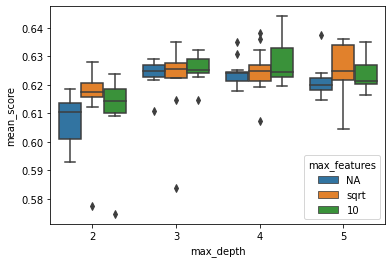

In [25]:
# GS results visualization
df = pd.DataFrame.from_records(gs_beva.cv_results_['params'])
df["mean_score"] = gs_beva.cv_results_['mean_test_score']
df["max_features"]= df["max_features"].fillna("NA")
sns.boxplot(data = df, y="mean_score", x= "max_depth", hue ="max_features")
plt.show()

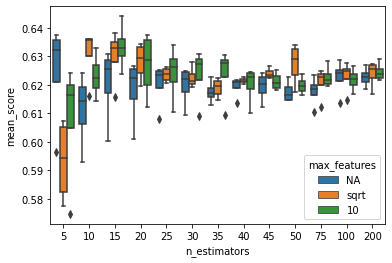

In [26]:
sns.boxplot(data = df, y="mean_score", x= "n_estimators", hue ="max_features")
plt.show()

In [27]:
permut_result_st, gs_st = run_RSF_and_calc_feature_importance(dasl_bics.loc[sele_bics_ids,:], annot_dasl, # DASL
                                                        uke_bics.loc[sele_bics_ids,:], annot, # UKE  
                                                        treatment_col = "bevacizumab",
                                                        treatment_value =0,
                                                        covariates = covariates,
                                                        surv_cols = [s+"_event",s+"_time"],
                                                        analysis_seed = analysis_seed,
                                                        n_permutations = n_permutations,
                                                        param_grid = param_grid
                                                        )
permut_result_st.columns = ["st_"+s+"."+x for x in permut_result_st.columns]

Fitting 5 folds for each of 156 candidates, totalling 780 fits
Best parameters: {'max_depth': 4, 'max_features': 10, 'n_estimators': 10}
Best score: 0.6474141770674164
RSF scores: Test: 0.58 (train: 0.74)


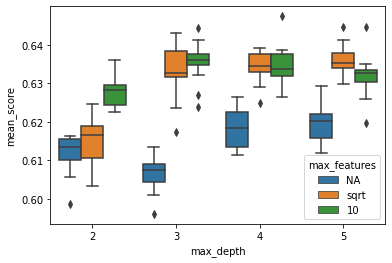

In [28]:
# GS results visualization
df = pd.DataFrame.from_records(gs_st.cv_results_['params'])
df["mean_score"] = gs_st.cv_results_['mean_test_score']
df["max_features"]= df["max_features"].fillna("NA")
sns.boxplot(data = df, y="mean_score", x= "max_depth", hue ="max_features")
plt.show()

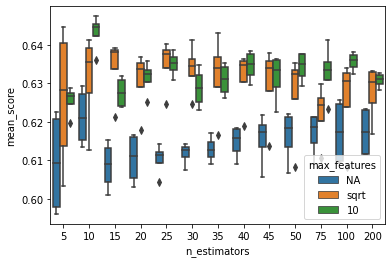

In [29]:
sns.boxplot(data = df, y="mean_score", x= "n_estimators", hue ="max_features")
plt.show()

In [30]:
shared_variables = [x for x in permut_result_beva.index.values if x in permut_result_st.index.values]
df = pd.concat([permut_result_beva.loc[shared_variables,:],
           permut_result_st.loc[shared_variables,:]],
          axis=1)
df["diff"] = df["beva_"+s+".importances_mean"] - df["st_"+s+".importances_mean"]
d = df.sort_values(by = "beva_"+s+".importances_mean",ascending = False).loc[:,["beva_"+s+".importances_mean","st_"+s+".importances_mean","diff"]]
d = d.loc[d["beva_"+s+".importances_mean"]>0,:]
d = d.loc[d["diff"]>0,:]
sele_features_beva =  d.index.values

sele_bics_beva = [int(x.replace("bic","")) for x in sele_features_beva if not x in covariates]
print(sele_features_beva)
print(sele_bics_beva)                 
d.loc[sele_features_beva,:]

['age' 'bic72' 'bic84' 'bic130' 'bic95' 'bic85']
[72, 84, 130, 95, 85]


,beva_OS.importances_mean,st_OS.importances_mean,diff
age,0.039033,0.004524,0.034510
bic72,0.012994,-0.001224,0.014218
bic84,0.011111,-0.024770,0.035881
bic130,0.005370,0.001743,0.003627
bic95,0.002329,-0.004889,0.007218
bic85,0.000066,-0.001180,0.001246


In [31]:
shared_variables = [x for x in permut_result_beva.index.values if x in permut_result_st.index.values]
df = pd.concat([permut_result_beva.loc[shared_variables,:],
           permut_result_st.loc[shared_variables,:]],
          axis=1)
df["diff"] = df["st_"+s+".importances_mean"] - df["beva_"+s+".importances_mean"]
d = df.sort_values(by = "st_"+s+".importances_mean",ascending = False).loc[:,["beva_"+s+".importances_mean","st_"+s+".importances_mean","diff"]]
d = d.loc[d["beva_"+s+".importances_mean"]>0,:]
d = d.loc[d["diff"]>0,:]
sele_features_st =  d.index.values
sele_bics_st = [int(x.replace("bic","")) for x in sele_features_st if not x in covariates]
print(sele_features_st)
print(sele_bics_st)                 
d

['OP_2' 'OP_1' 'bic90' 'bic155']
[90, 155]


,beva_OS.importances_mean,st_OS.importances_mean,diff
OP_2,0.009020,0.052068,0.043048
OP_1,0.001978,0.014172,0.012194
bic90,0.007923,0.009262,0.001339
bic155,0.003483,0.005376,0.001892


In [32]:
sele_bics_ids = sele_bics_beva
sele_bics_ids

[72, 84, 130, 95, 85]

# Predictive candidates

In [33]:
s

'OS'

In [34]:
from bic_survival_tests import test_predictive_biclusters
uke_os = test_predictive_biclusters(uke_bics.loc[sele_bics_ids,:],
                                annot,
                                treatment_col= "bevacizumab",
                                time_col = s+"_time",
                                event_col = s+"_event",
                                covariates = covariates, min_n_samples=10)

Biclusters tested: 5


In [35]:
fdr = 0.05
passed_uke = set(uke_os.loc[uke_os["min_adj_pval"]<fdr,:].index.values)
print(len(passed_uke))
uke_os.loc[passed_uke,:].sort_values(by=["min_adj_pval","min_pval"])#.head(30)

3


,bg.pval,bg.HR,bg.CI95,bg.beva,bg.st,bg.covar_excl,bic.pval,bic.HR,bic.CI95,bic.beva,bic.st,bic.covar_excl,direction,predictive,bevacizumab_eff,bic.pval_BH,bg.pval_BH,min_adj_pval,min_pval
84,0.003082,0.408457,"(0.22574659321570487, 0.7390472470560944)",39,60,[],0.968537,1.012052,"(0.5580419556101321, 1.8354346920918065)",28,54,[],DOWN,high,pos,0.968537,0.012054,0.012054,0.003082
130,0.004821,0.407069,"(0.21789966238664504, 0.7604667506921334)",35,78,[],0.17221,0.635371,"(0.33130581497885814, 1.218501722853906)",32,36,[],UP,low,pos,0.396166,0.012054,0.012054,0.004821
95,0.015949,0.500743,"(0.2853196295982275, 0.8788167162667687)",41,67,[],0.2377,0.666079,"(0.33930584204944797, 1.3075537477465624)",26,47,[],UP,low,pos,0.396166,0.026581,0.026581,0.015949


### With interaction term

In [38]:
from bic_survival_tests import test_predictive_with_interaction

In [39]:
surv_data = annot.loc[:,covariates+["bevacizumab",s+"_time",s+"_event"]]
#formula = "age + FIGO_IIIC + FIGO_IV + OP_1 + OP_2 + bevacizumab * bic"

df = test_predictive_with_interaction(uke_bics.loc[passed_uke,:],
                                     surv_data,
                                     covariates=covariates,
                                     treatment_col = "bevacizumab",
                                     duration_col=s+"_time",
                                     event_col= s+"_event",
                                     min_n_samples=10,
                                    )

print(df.shape[0])
df.loc[df["bevacizumab:bic_pval_BH"]<1].sort_values(by = ["bevacizumab:bic_pval_BH","bevacizumab:bic_pval"])

formula: FIGO_IIIC + FIGO_IV + OP_1 + OP_2 + age + bevacizumab * bic
3


,bevacizumab_bic,bevacizumab_bg,standard_bic,standard_bg,bevacizumab:bic_pval,bevacizumab:bic_HR,bevacizumab:bic_CI95,bevacizumab_pval,bevacizumab_HR,bevacizumab_CI95,bic_pval,bic_HR,bic_CI95,bevacizumab:bic_pval_BH,bevacizumab_pval_BH,bic_pval_BH
84,28,39,54,60,0.069179,2.095788,"(4.65512046354022, 0.9435475974347897)",0.007067,0.456542,"(0.8076980466074382, 0.2580556432520973)",0.681329,1.100887,"(1.7417003483229294, 0.6958441149051381)",0.207536,0.021201,0.906142
95,26,41,47,67,0.285721,1.56824,"(3.582427944474631, 0.686511181335922)",0.016503,0.504099,"(0.8824726433540417, 0.28795866002130893)",0.906142,0.973008,"(1.5333995484395293, 0.6174160438889931)",0.28696,0.02241,0.906142
130,32,35,36,78,0.28696,1.590459,"(3.736437188422762, 0.6769981683293766)",0.02241,0.498892,"(0.9062100877132652, 0.2746527342243978)",0.241324,0.741784,"(1.222571407450595, 0.45007014243340937)",0.28696,0.02241,0.723972


# validation in DASL 

In [40]:
print(len(passed_uke))

3


In [41]:
dasl_os = test_predictive_biclusters(dasl_bics.loc[passed_uke,:],
                                 annot_dasl, 
                                 treatment_col= "bevacizumab",
                                 time_col = s+"_time",
                                 event_col = s+"_event",
                                 covariates = covariates)

passed_dasl = dasl_os.loc[dasl_os["min_adj_pval"]<fdr,:].index.values
print(len(passed_dasl))
dasl_os.loc[passed_dasl,:]

Biclusters tested: 3
2


,bg.pval,bg.HR,bg.CI95,bg.beva,bg.st,bg.covar_excl,bic.pval,bic.HR,bic.CI95,bic.beva,bic.st,bic.covar_excl,direction,predictive,bevacizumab_eff,bic.pval_BH,bg.pval_BH,min_adj_pval,min_pval
84,0.00065,0.507434,"(0.34358167164567155, 0.7494261787624645)",101,94,[],0.870703,1.036488,"(0.6731995827634121, 1.595823674480094)",97,85,[],DOWN,high,pos,0.870703,0.00195,0.001950,0.000650
130,0.016754,0.680032,"(0.49580485061963775, 0.932714111809023)",174,151,[],0.516382,1.28076,"(0.6065744876064966, 2.704276159732652)",24,28,[],UP,low,pos,0.774573,0.025131,0.025131,0.016754


In [42]:
surv_data = annot_dasl.loc[:,covariates+["bevacizumab",s+"_time",s+"_event"]]

df = test_predictive_with_interaction(dasl_bics.loc[passed_uke,:],
                                     surv_data,
                                     covariates=covariates,
                                     treatment_col = "bevacizumab",
                                     duration_col=s+"_time",
                                     event_col= s+"_event",
                                     min_n_samples=10,
                                    )

print(df.shape[0])
df.loc[df["bevacizumab:bic_pval"]<fdr,:].sort_values(by = ["bevacizumab:bic_pval_BH","bevacizumab:bic_pval"])

formula: FIGO_IIIC + FIGO_IV + OP_1 + OP_2 + age + bevacizumab * bic
3


,bevacizumab_bic,bevacizumab_bg,standard_bic,standard_bg,bevacizumab:bic_pval,bevacizumab:bic_HR,bevacizumab:bic_CI95,bevacizumab_pval,bevacizumab_HR,bevacizumab_CI95,bic_pval,bic_HR,bic_CI95,bevacizumab:bic_pval_BH,bevacizumab_pval_BH,bic_pval_BH
84,97,101,85,94,0.013626,2.061498,"(3.6626561476239523, 1.1602987123755164)",0.000872,0.521548,"(0.765142267308274, 0.3555061834814814)",0.092818,0.696451,"(1.0619485568462221, 0.4567493788511178)",0.040879,0.002615,0.278455


In [43]:
uke_os.loc[passed_dasl,["direction","predictive","bevacizumab_eff",
                        "bg.pval","bic.pval","bg.HR","bic.HR"]]

,direction,predictive,bevacizumab_eff,bg.pval,bic.pval,bg.HR,bic.HR
84,DOWN,high,pos,0.003082,0.968537,0.408457,1.012052
130,UP,low,pos,0.004821,0.17221,0.407069,0.635371


In [44]:
dasl_os.loc[passed_dasl,["direction","predictive","bevacizumab_eff",
                         "bg.pval","bic.pval","bg.HR","bic.HR"]]

,direction,predictive,bevacizumab_eff,bg.pval,bic.pval,bg.HR,bic.HR
84,DOWN,high,pos,0.00065,0.870703,0.507434,1.036488
130,UP,low,pos,0.016754,0.516382,0.680032,1.28076


In [45]:
reproduced_bic_ids = uke_os.loc[passed_dasl,["predictive","bevacizumab_eff"]] == dasl_os.loc[passed_dasl,["predictive","bevacizumab_eff"]]
reproduced_bic_ids =reproduced_bic_ids.apply(lambda row: np.all(row),axis=1)
reproduced_bic_ids = list(reproduced_bic_ids[reproduced_bic_ids].index)
reproduced_bic_ids 

[84, 130]

### KM-plots predictive 

In [46]:
s

'OS'

UP
(0.33130581497885814, 1.218501722853906)
bicluster p-val.=1.72e-01, adj.p-val.=3.96e-01, HR=0.64(0.33,1.22);
(0.21789966238664504, 0.7604667506921334)
background p-val.=4.82e-03, adj.p-val.=1.21e-02, HR=0.41(0.22,0.76);
130 113


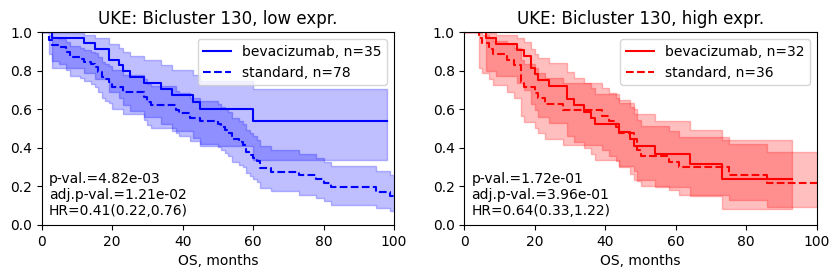

In [47]:
from bic_survival_plots import plot_KM_predictive
bic_id =  130
bic_samples = uke_bics.loc[bic_id,"samples"].intersection(set(annot.index.values))
stats =   uke_bics.loc[bic_id,"direction"]
print(stats)

plot_KM_predictive(bic_samples, annot, uke_os, bic_id, stats,
                       surv_time = s+"_time",
                   surv_event= s+"_event",
                       cohort = "UKE",
                   xlabel = s+", months",
                   add_at_risk_counts=False,
                   label_pos=(2,0.05)
                  )
                    

(0.6065744876064966, 2.704276159732652)
bicluster p-val.=5.16e-01, adj.p-val.=7.75e-01, HR=1.28(0.61,2.70);
(0.49580485061963775, 0.932714111809023)
background p-val.=1.68e-02, adj.p-val.=2.51e-02, HR=0.68(0.50,0.93);
130 325


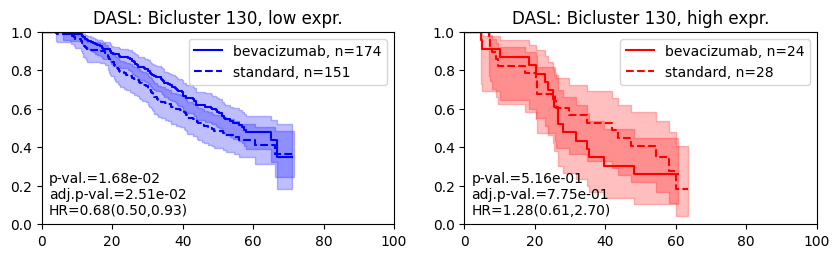

In [48]:
bic_samples = dasl_bics.loc[bic_id,"samples"].intersection(set(annot_dasl.index.values))
d = dasl_bics.loc[bic_id,"direction"]
plot_KM_predictive(bic_samples, annot_dasl, dasl_os, bic_id, d,
                       surv_time = s+"_time", surv_event= s+"_event",
                       cohort = "DASL",add_at_risk_counts=False, label_pos=(2,0.05))

### Plot biclusters 

In [51]:
color_dict = {"bevacizumab":{0:"lightgrey",1:"darkgreen"},
              "consensusOV":{
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan"
    },
    "subtype":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan",
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan",
    },
    "Bentink":{
    'Angiogenic':'violet',
    'nonAngiogenic':'gold'},
}

subt_dir = "../data/OVcancer_subtypes/"
uke_subt = pd.read_csv(subt_dir+"UKE181_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)
dasl_subt = pd.read_csv(subt_dir+"DASL_Kommoss_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)

dasl_subt["subtype"]=dasl_subt["consensusOV"]
uke_subt["subtype"]=uke_subt["consensusOV"]

In [52]:
exprs_z_rn = rename_genes_in_exprs(exprs_z.copy())

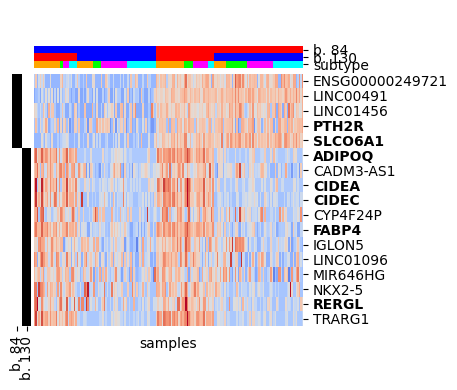

In [57]:
from unpast.utils.figs import draw_heatmap2

i = reproduced_bic_ids  
b = rename_genes_in_biclusters(uke_bics.loc[i,:].copy())


tmp = draw_heatmap2(exprs_z_rn.loc[:,annot.index], b,
                    annot=uke_subt.loc[:,["subtype"]],
                    color_dict=color_dict,
              bicluster_colors="redblue",
              figsize = (5,4), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.03, 0.03/10*8),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = True,
              highlight_row_labels=["PTH2R","SLCO6A1",
              "ADIPOQ","CIDEA","CIDEC","PLIN1","CD300LG","FABP4","RERGL",
                                   "EMX2","EMX2OS","FAM181A","CTCFL"],
                no_row_colors = False,cluster_rows=False
             )
plt.show()

In [58]:
cols = ["bic"+str(x) for x in reproduced_bic_ids]
df = pd.DataFrame(np.zeros((annot.shape[0],len(cols))),
             index=annot.index,
             columns=cols)
for bic_id in reproduced_bic_ids:
    df.loc[uke_bics.loc[bic_id,"samples"],"bic"+str(bic_id)]=1
df = df.applymap(lambda x: int(x))
df.to_csv("UKE_181.design.tsv",sep ="\t")


In [55]:
exprs_z_dasl = zscore(exprs_dasl.copy())
exprs_z_rn_dasl = rename_genes_in_exprs(exprs_z_dasl.copy())

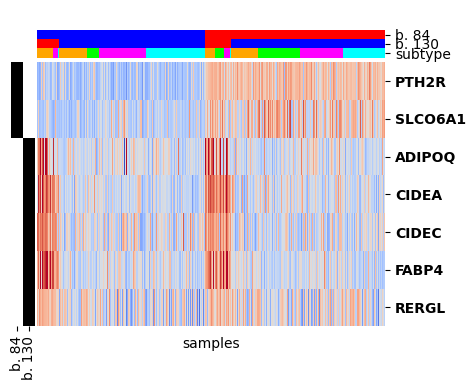

In [59]:
i = reproduced_bic_ids
b = rename_genes_in_biclusters(dasl_bics.loc[i,:].copy())

tmp = draw_heatmap2(exprs_z_rn_dasl.loc[:,annot_dasl.index], b,
                    annot=dasl_subt.loc[:,["subtype"]],
                    color_dict=color_dict,
              bicluster_colors="redblue",
              figsize = (5,4), 
              dendrogram_ratio=(0.05,0.05),
              colors_ratio=(0.03, 0.03),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = True,
              highlight_row_labels=["PTH2R","SLCO6A1",
              "ADIPOQ","CIDEA","CIDEC","PLIN1","CD300LG", "FABP4","RERGL",
                                   "EMX2","EMX2OS","FAM181A"],
                no_row_colors = False,cluster_rows=False
             )
plt.show()

In [60]:
cols = ["bic"+str(x) for x in reproduced_bic_ids]
df = pd.DataFrame(np.zeros((exprs_dasl.shape[1],len(cols))),
             index=exprs_dasl.columns,
             columns=cols)
for bic_id in reproduced_bic_ids:
    df.loc[dasl_bics.loc[bic_id,"samples"],"bic"+str(bic_id)]=1
df = df.applymap(lambda x: int(x))
df.to_csv("DASL_377.design.tsv",sep ="\t")

# DE analysis

In [62]:
lfc = 1
p = 0.01#1e-5 #0.01
de_shared = {}
query_gset_dict = {}
for i in reproduced_bic_ids:
    de_shared[i]={}
    de = pd.read_csv("../bic"+str(i)+"_UKE181.DE.tsv",sep = "\t")
    de = de.loc[de["adj.P.Val"]<p,:]
    de_up = de.loc[de["logFC"]>lfc,:].index.values
    de_down = de.loc[de["logFC"]<-lfc,:].index.values
    de2 = pd.read_csv("../bic"+str(i)+"_DASL377.DE.tsv",sep = "\t")
    de2 = de2.loc[de2["adj.P.Val"]<p,:]
    de2_up = de2.loc[de2["logFC"]>lfc,:].index.values
    de2_down = de2.loc[de2["logFC"]<-lfc,:].index.values
    print("\t UKE bic.%s:"%i,len(de_up),len(de_down) )
    print("\t DASL bic.%s:"%i,len(de2_up),len(de2_down) )
    if uke_bics.loc[i,"direction"] == dasl_bics.loc[i,"direction"]:
        shared_up = set(de_up).intersection(set(de2_up))
        shared_down = set(de_down).intersection(set(de2_down))
    else:
        shared_up = set(de_up).intersection(set(de2_down))
        shared_down = set(de_down).intersection(set(de2_up))
    print("\t DASL shared.%s:"%i,len(shared_up),len(shared_down) )
    de_shared[i]["genes"] = shared_up | shared_down
    de_shared[i]["genes_up"] = shared_up
    de_shared[i]["genes_down"] = shared_down
    print(i,len(shared_up | shared_down))
    query_gset_dict.update({"UKEbic"+str(i)+"_up":uke_bics.loc[i,"genes_up"],
                            "UKEbic"+str(i)+"_down":uke_bics.loc[i,"genes_down"]})
    query_gset_dict.update({"DASLbic"+str(i)+"_up":dasl_bics.loc[i,"genes_up"],
                            "DASLbic"+str(i)+"_down":dasl_bics.loc[i,"genes_down"]})
    query_gset_dict.update({"shared_"+str(i)+"_up":shared_up,"shared_"+str(i)+"_down":shared_down}
    )
de_shared=pd.DataFrame.from_dict(de_shared).T
#de_shared=de_shared.loc[reproduced_bic_ids,:]
de_shared

	 UKE bic.84: 1 224
	 DASL bic.84: 12 37
	 DASL shared.84: 0 10
84 10
	 UKE bic.130: 817 5
	 DASL bic.130: 116 4
	 DASL shared.130: 96 0
130 96


,genes,genes_up,genes_down
84,"{ENSG00000280409, ENSG00000127928, ENSG0000020...",{},"{ENSG00000280409, ENSG00000127928, ENSG0000020..."
130,"{ENSG00000126353, ENSG00000163599, ENSG0000009...","{ENSG00000126353, ENSG00000130876, ENSG0000000...",{}


In [63]:
#" ".join(de_shared.loc[130,"genes_up"])

'ENSG00000126353 ENSG00000130876 ENSG00000007312 ENSG00000139329 ENSG00000181092 ENSG00000102468 ENSG00000132185 ENSG00000134762 ENSG00000174697 ENSG00000170323 ENSG00000173641 ENSG00000178199 ENSG00000151892 ENSG00000078098 ENSG00000039537 ENSG00000105996 ENSG00000145824 ENSG00000145423 ENSG00000103196 ENSG00000143867 ENSG00000170961 ENSG00000276409 ENSG00000188404 ENSG00000127954 ENSG00000105509 ENSG00000158481 ENSG00000137077 ENSG00000157150 ENSG00000154262 ENSG00000133110 ENSG00000115380 ENSG00000184254 ENSG00000107562 ENSG00000138135 ENSG00000182747 ENSG00000174175 ENSG00000115602 ENSG00000140287 ENSG00000143196 ENSG00000172724 ENSG00000108381 ENSG00000113263 ENSG00000163508 ENSG00000164530 ENSG00000151789 ENSG00000163599 ENSG00000091986 ENSG00000016082 ENSG00000166819 ENSG00000241644 ENSG00000135218 ENSG00000101955 ENSG00000060718 ENSG00000162739 ENSG00000087245 ENSG00000127083 ENSG00000050628 ENSG00000094963 ENSG00000178860 ENSG00000165269 ENSG00000106511 ENSG00000132465 ENSG000

# permutation test

In [64]:
from permutations import do_permutations_for_predictive, calc_perm_pval
from bic_survival_tests import test_samples_predictive
#from statsmodels.stats.multitest import fdrcorrection

In [65]:
data_dict = {"UKE":{"annot":annot, "biclusters":uke_bics},
             "DASL":{"annot":annot_dasl, "biclusters":dasl_bics}
            }

perm_results = []
for ds in ["UKE","DASL"]:
    all_samples = set(data_dict[ds]["annot"].index)
    for i in reproduced_bic_ids:
        for group in ["bicluster", "background"]:
            if group == "bicluster":
                samples = data_dict[ds]["biclusters"].loc[i,"samples"] # bicluster
            else:
                # test background group
                samples = all_samples.difference(data_dict[ds]["biclusters"].loc[i,"samples"])
                print(group)
            perm_res = {"dataset":ds,"bic":i,"group":group}
            sample_data = data_dict[ds]["annot"].copy()
            hr, ci, pval, cov_excl = test_samples_predictive(sample_data,
                                        samples, # compare treatments in this sample group
                                        covariates = covariates,
                                        treatment_col = "bevacizumab",
                                        time_col = s+"_time",
                                        event_col = s+"_event"
                                       )
            perm_res.update({"HR":hr,"CI95":ci,"pval":pval})
            print("%s %s %s: HR %.2f(%.2f-%.2f), pval = %.2e"%(ds,group, i, hr, ci[0],ci[1], pval))

            perm_data = do_permutations_for_predictive(sample_data, samples,
                                               covariates = covariates,
                                               treatment_col = "bevacizumab",
                                               time_col = s+"_time",
                                               event_col = s+"_event",
                                               n_perm = 1000,
                                               seed = analysis_seed
                                              )
            perm_pval,rand_avg_hr = calc_perm_pval(perm_data,hr)
            perm_res.update({"perm.pval":perm_pval, "perm_HR":rand_avg_hr})
            print("%s: %s %s: avg.HR for permuted data:%.2f"%(ds, group, i,rand_avg_hr),"perm.pval < %.2e"%perm_pval)
            perm_results.append(perm_res)
pd.DataFrame.from_records(perm_results)

UKE bicluster 84: HR 1.01(0.56-1.84), pval = 9.69e-01
UKE: bicluster 84: avg.HR for permuted data:1.06 perm.pval < 6.19e-01
background
UKE background 84: HR 0.41(0.23-0.74), pval = 3.08e-03
UKE: background 84: avg.HR for permuted data:0.71 perm.pval < 1.00e-03
UKE bicluster 130: HR 0.64(0.33-1.22), pval = 1.72e-01
UKE: bicluster 130: avg.HR for permuted data:0.89 perm.pval < 2.90e-02
background
UKE background 130: HR 0.41(0.22-0.76), pval = 4.82e-03
UKE: background 130: avg.HR for permuted data:0.80 perm.pval < 1.00e-03
DASL bicluster 84: HR 1.04(0.67-1.60), pval = 8.71e-01
DASL: bicluster 84: avg.HR for permuted data:0.94 perm.pval < 1.58e-01
background
DASL background 84: HR 0.51(0.34-0.75), pval = 6.50e-04
DASL: background 84: avg.HR for permuted data:0.71 perm.pval < 3.00e-03
DASL bicluster 130: HR 1.28(0.61-2.70), pval = 5.16e-01
DASL: bicluster 130: avg.HR for permuted data:1.35 perm.pval < 5.36e-01
background
DASL background 130: HR 0.68(0.50-0.93), pval = 1.68e-02
DASL: backgro

,dataset,bic,group,HR,CI95,pval,perm.pval,perm_HR
0,UKE,84,bicluster,1.012052,"(0.5580419556101321, 1.8354346920918065)",0.968537,0.619,1.061785
1,UKE,84,background,0.408457,"(0.22574659321570487, 0.7390472470560944)",0.003082,0.001,0.711210
2,UKE,130,bicluster,0.635371,"(0.33130581497885814, 1.218501722853906)",0.172210,0.029,0.891439
3,UKE,130,background,0.407069,"(0.21789966238664504, 0.7604667506921334)",0.004821,0.001,0.798146
4,DASL,84,bicluster,1.036488,"(0.6731995827634121, 1.595823674480094)",0.870703,0.158,0.935926
5,DASL,84,background,0.507434,"(0.34358167164567155, 0.7494261787624645)",0.000650,0.003,0.713853
6,DASL,130,bicluster,1.280760,"(0.6065744876064966, 2.704276159732652)",0.516382,0.536,1.349351
7,DASL,130,background,0.680032,"(0.49580485061963775, 0.932714111809023)",0.016754,0.001,0.798040


In [66]:
pd.DataFrame.from_records(perm_results)

,dataset,bic,group,HR,CI95,pval,perm.pval,perm_HR
0,UKE,84,bicluster,1.012052,"(0.5580419556101321, 1.8354346920918065)",0.968537,0.619,1.061785
1,UKE,84,background,0.408457,"(0.22574659321570487, 0.7390472470560944)",0.003082,0.001,0.711210
2,UKE,130,bicluster,0.635371,"(0.33130581497885814, 1.218501722853906)",0.172210,0.029,0.891439
3,UKE,130,background,0.407069,"(0.21789966238664504, 0.7604667506921334)",0.004821,0.001,0.798146
4,DASL,84,bicluster,1.036488,"(0.6731995827634121, 1.595823674480094)",0.870703,0.158,0.935926
5,DASL,84,background,0.507434,"(0.34358167164567155, 0.7494261787624645)",0.000650,0.003,0.713853
6,DASL,130,bicluster,1.280760,"(0.6065744876064966, 2.704276159732652)",0.516382,0.536,1.349351
7,DASL,130,background,0.680032,"(0.49580485061963775, 0.932714111809023)",0.016754,0.001,0.798040


# Prognostic value

In [67]:
from bic_survival_tests import test_biclusters_prognostic
from bic_survival_plots import plot_KM_prognostic

In [68]:
s, sele_bics_ids

('OS', [72, 84, 130, 95, 85])

In [89]:
min_n_samples = 10
tr = 1

cols = covariates+[s+"_event",s+"_time"]
surv_data = annot.copy().loc[annot["bevacizumab"]==tr,cols]

stats = test_biclusters_prognostic(uke_bics.copy().loc[sele_bics_ids,:],
                                   surv_data,
                                   surv_event = s +"_event",
                                   surv_time = s +"_time",
                                   covariates = covariates,
                                   min_n_samples=min_n_samples)
stats.loc[stats["adj_pval"]<fdr,:]

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval


In [90]:
stats.loc[reproduced_bic_ids,:] 

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval
84,39.0,28.0,0.396212,0.192884,0.813875,0.011712,0.058561
130,32.0,35.0,1.523793,0.656961,3.534371,0.326479,0.326479


In [91]:
stats.loc[stats["pval"]<0.05,:]

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval
84,39.0,28.0,0.396212,0.192884,0.813875,0.011712,0.058561


84 67 39 28


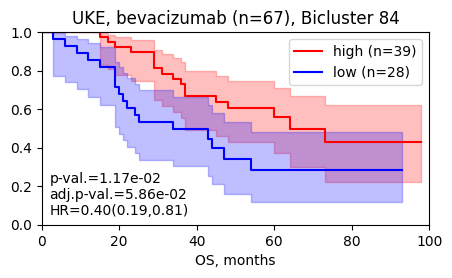

130 67 32 35


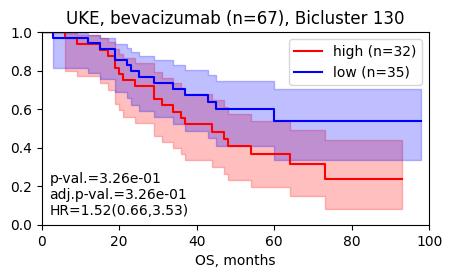

In [92]:
plot_KM_prognostic(uke_bics.loc[reproduced_bic_ids,:],
                   surv_data,
                   stats,
                   treatment ="bevacizumab", #"standard" "bevacizumab"
                   surv_time=s+'_time',
                   surv_event=s+'_event',
                   xlabel= s+", months",
                   cohort = "UKE",
                  )

### DASL

In [93]:
cols = covariates+[s+"_event",s+"_time"]
surv_data = annot_dasl.copy().loc[annot_dasl["bevacizumab"]==tr,cols]

stats = test_biclusters_prognostic(dasl_bics.copy().loc[sele_bics_ids,:],
                                   surv_data,
                                   surv_event = s +"_event",
                                   surv_time = s +"_time",
                                   covariates = covariates,
                                   min_n_samples=min_n_samples)
stats.loc[stats["adj_pval"]<fdr,:]

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval
130,24.0,174.0,2.866639,1.649579,4.981647,0.000188,0.000938


In [94]:
stats.loc[reproduced_bic_ids,:] 

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval
84,101.0,97.0,0.651206,0.429929,0.986371,0.042894,0.107234
130,24.0,174.0,2.866639,1.649579,4.981647,0.000188,0.000938


In [95]:
stats.loc[stats["pval"]<0.05,:]

,n_up,n_down,HR,CI_l,CI_r,pval,adj_pval
130,24.0,174.0,2.866639,1.649579,4.981647,0.000188,0.000938
84,101.0,97.0,0.651206,0.429929,0.986371,0.042894,0.107234


84 198 101 97


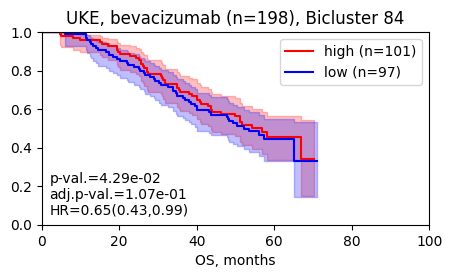

130 198 24 174


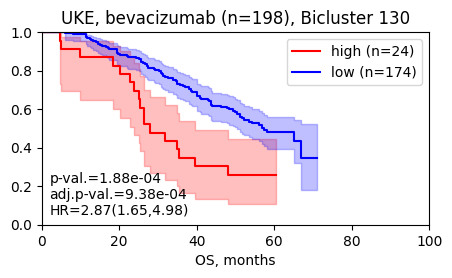

In [96]:
plot_KM_prognostic(dasl_bics.loc[reproduced_bic_ids ,:],
                surv_data,
                   stats,
                   treatment ="bevacizumab", #"standard" "bevacizumab"
                   surv_time=s+'_time',
                   surv_event=s+'_event',
                   xlabel= s+", months",
                   cohort = "UKE",)

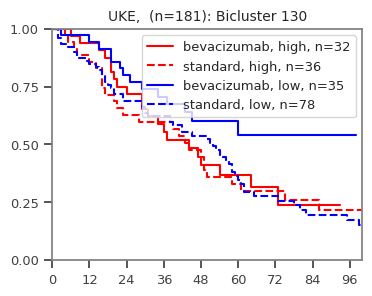

In [97]:
from bic_survival_plots import plot_KM_four
    
bic_id = 130 # 70,130 [84, 60, 83, 130, 168, 155, 103, 109, 70]
figsize = (4,3)
bic_samples = uke_bics.loc[bic_id,"samples"].intersection(set(annot.index.values))
d = uke_bics.loc[bic_id,"direction"]   

plot_KM_four(bic_samples,
             annot, bic_id, 
             d,
             surv_time = s+"_time",
             surv_event= s+"_event",
             cohort = "UKE, ",
             #add_counts=True,
             figsize=figsize,
             label_pos=(110,0.35),
            )

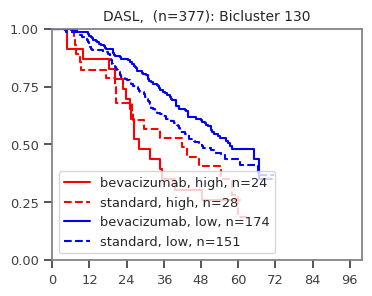

In [98]:
bic_samples = dasl_bics.loc[bic_id,"samples"].intersection(set(annot_dasl.index.values))
d = dasl_bics.loc[bic_id,"direction"]   

plot_KM_four(bic_samples,
             annot_dasl, bic_id, d,
             surv_time = s+"_time",
             surv_event= s+"_event",
             cohort = "DASL, ",
             #add_counts=True,
             figsize=figsize,
             add_counts=False)
                       

In [99]:
uke_bics.loc[72,"genes"]

{'ENSG00000077935', 'ENSG00000240280'}